# Submodule 2: Assessment of genome assembly and genome annotation
--------
## Overview
In this submodule, you will begin with the genome that you assembled in Submodule 1. The primary goal of this submodule is to assess the quality of the assembled genome through the lens of what we call the "5 Cs":

1. Contiguity,
2. Completeness,
3. Contamination,
4. Coverage, and
5. Content.

By utilizing a combination of bioinformatics tools, participants will evaluate the assembled genome and generate outputs that include visualizations, a cleaned genome sequence and functional annotations. These outputs will be used in submodule 4.


### Learning Objectives
Through this submodule, users will gain hands-on experience in quality assessment, resulting in a deeper understanding of genomic data integrity and the significance of accurate genome sequences.

- **Understand and Apply the 5 Cs of Genome Quality**:  
  Understand how to assess the overall quality of a genome sequence by examing Contiguity (QUAST), Completeness (BUSCO), Contamination (BLAST/BlobTools), Coverage (BWA/Samtools), and Content (Prokka gene annotations).

- **Understand Core Bioinformatic File Formats and Interpret Visualizations**:  
  Gain proficiency in using bioinformatics tools and foster skills in data analysis and interpretation.

- **Relate the Central Dogma of Molecular Biology to Genome Annotation**:  
  Connect the principles of the central dogma (DNA → RNA → Protein) to the process of genome annotation, understanding how gene annotations contribute to functional genomics and biological interpretations.

- **Produce a Clean and Annotated Genome**:  
  Participants will refine the genome based on their assessments, ensuring a high-quality, annotated genome that can be used for further analysis or research applications.

## **Install required software**

Several additional tools are required for Submodule 2; quast, busco, bwa, samtools, blast, blobtools, and bakta.  As with submodule 1, tools are preinstalled into a docker image, but we will demonstrate how to install these tools using __[Conda](https://docs.conda.io/en/latest/)__.

Each piece of software, along with links to publications and documentation, will be described in turn. Below is a brief summary of these tools.

### List of software
| **Tool**       | **Description**                                                                                                                                                           |
|:---------------|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **QUAST**      | Used for evaluating and reporting the quality of genome assemblies by comparing them against reference genomes or generating statistical summaries.                          |
| **BUSCO**      | Utilized for assessing genome completeness by searching for conserved single-copy orthologs from specific lineage datasets.                                                 |
| **BWA**        | A fast and memory-efficient tool for aligning sequence reads to large reference genomes, commonly used in variant calling pipelines.                                         |
| **Samtools**   | Used for manipulating and processing sequence alignments stored in SAM/BAM format. Essential for sorting, indexing, and viewing alignment files.                            |
| **BLAST**      | A widely used tool for comparing an input sequence to a database of sequences, identifying regions of local similarity and aiding in functional annotation.                  |
| **BlobTools**  | A versatile tool for visualizing and analyzing genome assemblies, helping to identify contamination or misassembled regions by correlating sequence features with taxonomy.   |
| **Bakta**     | Used for annotation of prokaryotic genomes, identifying genes, coding sequences, rRNAs, tRNAs, and other genomic features.                                             |

In [ ]:
%%bash

# Install all tools using mamba (a conda alternative) with specific versions

echo "mamba install --channel bioconda \
    quast=5.2.0 \
    busco=5.4.6 \
    bwa=0.7.18 \
    samtools=1.18 \
    blast=2.15.0 \
    blobtools=1.0.1 \
    bakta=1.9.4 \
    -y > /dev/null 2>&1"

echo "Installation of quast, busco, bwa, samtools, blast, blobtools, and bakta complete."

quast.py --version
busco --version
bakta --version

## Starting Data

This submodule starts with the **genome FASTA** file, this will be the primary input for all programs. We will define this as the variable *genome* now, and use that for the remainder of the workflow. This enables the starting data to be easily changed if a user wants to run this tutorial with their own data.

We will also need to original reads from Submodule 1 for the read mapping step. We will use BWA to calculate sequencing coverage and it requires **paired-end sequencing reads in FASTQ format**. We will define these here as *forward* for the R1 sequencing reads and *reverse* for the R2 sequencing reads.

In [ ]:
%%bash

# starting genome from submodule 1
prev_genome=assembled-genome/genome.fasta

# raw reads from submodule 1
prev_forward=raw-reads/reads_1.fastq.gz
prev_reverse=raw-reads/reads_2.fastq.gz

# link to a new location (so we can use custom datasets)
mkdir -p submodule02_data/
genome=submodule02_data/genome.fasta
forward=submodule02_data/reads_1.fastq.gz
reverse=submodule02_data/reads_2.fastq.gz

# Create symbolic links using absolute paths (this way it doesn't use more space)
ln -s "$(realpath "$prev_genome")" $genome
ln -s "$(realpath "$prev_reverse")" $reverse
ln -s "$(realpath "$prev_forward")" $forward

ls submodule02_data/

## Process 1: **Contiguity** assessment using QUAST
- Program: **QUAST (Quality Assessment Tool for Genome Assemblies)**
- Citation: *Gurevich, A., Saveliev, V., Vyahhi, N., & Tesler, G. (2013). QUAST: quality assessment tool for genome assemblies. Bioinformatics, 29(8), 1072-1075.*
- Manuscript: [https://pubmed.ncbi.nlm.nih.gov/23422339/](https://pubmed.ncbi.nlm.nih.gov/23422339/)
- Manual: https://github.com/ablab/quast

QUAST is a tool used to evaluate and compare the quality of genome assemblies by providing metrics such as N50, number of contigs, genome length, and misassemblies. Did you get one contig representing your entire genome? Or did you get thousands of contigs representing a highly fragmented genome?

QUAST has many functionalities which we will not explore in this tutorial, I encourage you to explore these, for now we are going to use it in its simplest form. The program parses the genome FASTA file and records statsitics about each contig, the length, GC content etc. This type of information is something you would typically provide in a publication or as a way to assess different assemblers/options you may use. 

The **input** to the program is the genome assembly **FASTA** and the output are various tables and an html/pdf you can export and view.

In [ ]:
%%bash

genome=submodule02_data/genome.fasta
echo "Running QUAST on genome FASTA file:" $genome

# run quast on the genome assembly
quast.py $genome -o output-quast > logfile_quast.txt 2>&1

# display output directory contents
echo "QUAST complete, output directory contents:"
ls -l output-quast/*

In [ ]:
%%bash

# open output file
cat output-quast/report.txt

In [ ]:
from IPython.display import IFrame
from IPython.display import Image
IFrame('output-quast/report.html', width=1000, height=550)

### Explanation of QUAST outputs
We used QUAST to assess the contiguity of the genome assembly, the results describes how well the genome was put back together. These statistics allow us to describe our dataset within a manuscript and us allow us to compare different assembly programs, algorithms, and parameters. As mentioned in Submodule01, a typical bacterial genome consists of a single circular chromosome, so ideally, we would expect to end up with a single contig. Unfortunately, this is rarely the case, for reasons we will discuss below.

The QUAST report we displayed above provides some basic statistics about our genome assembly. Focus your attention on the values starting at '# contigs'. As described at the top of the report, these statistics are based on all contigs in the library with length >= 500 bps, a typical cutoff for genome assembly submissions. NCBI accepts submission of contigs >= 250 bps in their genome assembly database.

#### Focused Results
```
# contigs                   30      
Largest contig              512,707  
Total length                1,693,722 
GC (%)                      30.29   
N50                         180742  
L50                         3       
```

The *de novo* genome assembly resulted in a **total length of 1,693,722 bp across 30 contigs**. If the species of interest is known, you can compare the total genome length against publically available datasets. 

The **N50 of the assemly is 180,742 bp** , meaning that half of the total assembly length is contained in contigs that are at least this long. N50 is a widely used metric for assessing contiguity, with higher N50 values indicating better assembly quality. The **L50 is 3**, which complements the N50 by showing the smallest number of contigs needed to cover half the genome length. In this case, **the three longest contigs account for at least half of the assembly**. Metrics like N90 and L90 are similar to N50 and L50 but focus on 90% of the genome length.

What qualifies as a "good" N50 or other metrics depends on the genome being assembled. Larger, more contiguous genomes, such as those with high N50 and low L50, are generally considered better. However, this also depends on the complexity of the organism and the sequencing approach used.

QUAST also provides us with the **GC content (30.29%)**, a metric describing the nucleotide composition of the genome. According to **Chargaff's second rule** (see below), GC content is generally constant within a species but can vary widely between unrelated species. GC content vaires significantly across species and comparing the value can provide clues about evolutionary relationships, ecological adaptations, and functional constraints.


## Chargaff's Second Rule

Chargaff's **second rule** states that within a double-stranded DNA molecule, the base composition is species-specific but exhibits certain patterns:

1. **Base Pair Equality**: The proportion of adenine (A) roughly equals the proportion of thymine (T), and the proportion of guanine (G) roughly equals the proportion of cytosine (C). This rule is foundational to the understanding of complementary base pairing in DNA.
   - %A ≈ %T
   - %G ≈ %C
       
2. **Species-Specific GC Content**: While the total GC content (\(%G + %C\)) and AT content (\(%A + %T\)) can vary widely between species, they are relatively consistent within the genome of a given species. This variation is a hallmark of species identity and evolutionary lineage.

### Example
A genome with 40% GC content will have 60% AT content, but the exact proportions of G and C will always be equal.

---

### Significance of Chargaff's Second Rule

1. **Foundation for Watson and Crick's Model**: Chargaff's observations were critical for deducing the double-helix structure of DNA, where base pairing (A-T and G-C) ensures the rules hold true.

2. **Comparative Genomics**: The species-specific nature of GC content allows researchers to use it as a comparative tool for identifying evolutionary relationships, detecting horizontal gene transfer, or distinguishing between microbial strains.

3. **Genome Assembly Quality**: Deviations from expected GC content in an assembly may indicate errors, contamination, or sequencing biases, making it a valuable metric in genome analysis tools like QUAST.

---

In essence, Chargaff's second rule highlights the balance and specificity in DNA's molecular composition, emphasizing both its biochemical properties and its role in evolution and species differentiation.

In [ ]:
%%bash

# Save select Quast Results into log file
log_file="genome-assessment-log.txt"

echo "Saving Select Quast Results in log file"
echo "Contiguity (Quast) results:" > $log_file
grep -A 4 "# contigs" output-quast/report.txt | tail -n 5 >> $log_file
echo "----------------------------------" >> $log_file

cat $log_file

## Process 2: **Completeness** assessment using BUSCO

- Program: **BUSCO - Benchmarking Universal Single-Copy Orthologs**
- Citation: *Seppey, M., Manni, M., & Zdobnov, E. M. (2019). BUSCO: assessing genome assembly and annotation completeness. Gene prediction: methods and protocols, 227-245.*  
- Manual: https://busco.ezlab.org/

BUSCO is a program utilized to assess the completeness of a genome assembly in terms of the number of found and universal genes. This program makes use of the OrthoDB set of single-copy orthologous that are found in at least 90% of all the organisms in question. There are different data sets for various taxonomic groups (Eukaryotes, Metazoa, Bacteria, Gammaproteobacteria, etc. etc.). The idea is that a newly sequenced genome *should* contain most of these highly conserved genes. If your genome doesn't contain a large portion of these single-copy orthologs it may indicate that your genome is not complete.


<p align="center">
  <img src="images/busco_sampling.png" width="40%"/>
</p>


The input to the program is your genome assembly (contigs) as well as a selection of which database to use. The output is a directory with a short summary of the results, a full table with coordinates for each orthologous gene is located in your assembly, and a directory with the nucleotide and amino acid sequences of all the identified sequences.

We will focus on the main summary output as a way to provide a simple QC assessment of our assembly, the outputs provided by BUSCO however have many uses, such as phylogenomics and gene prediction.

<div class="alert alert-block alert-info"><b>Note</b>: The code below requires an active internet connection, it downloads the most recent version of the database and provides a list of all available datasets that you can use with the tool.</div>

In [ ]:
%%bash

# View available sets
busco --list-datasets

In [ ]:
%%bash

# starting data
genome=submodule02_data/genome.fasta

# lineage to search against
lineage=bacteria

# run BUSCO
busco -i $genome -m genome -o output-busco -l $lineage --cpu 24 -f

### Explanation of BUSCO output
The output displayed above provides a summary of the BUSCO completeness analysis. See the output file 'short_summary_busco_output.txt' for the detaile report. This is a file which summarizes the main findings, how many of the expected genes did we find? This summary breaks the report into four main categories: **complete single-copy genes, complete duplicated genes, fragmented genes, and missing genes**. 

We are hopeful that the majority of our genes will be found as 'complete single-copy'. Duplicated genes could indicate that that particular gene underwent a gene duplication event or that we had a miss assembly and essentially have two copies of a region of our genome. Fragmented genes are an artifact of the fact that our genome did not assemble perfectly. Some of our genome is fragmented into multiple contigs, and with that some of our genes are going to be fragmented as well. This is why it is important to inspect the N50 of the genome with QUAST. We want the majority of our contigs to be at least as big as a gene, if it's not than we will have many fragmented genes as a result.

We anticipate that most, if not all, BUSCO genes will be present in our dataset. Our results show seven missing BUSCOs. This may be due to the initial subsetting of our sequencing reads; however, it is more likely that this particular species does not contain these genes. Remember, BUSCO genes are expected to be present in ~90% of species, not all. It is worthwhile to run BUSCO on reference genomes from NCBI for your species of interest and compare the list of missing gene IDs.

### Other BUSCO results

Next we will view the 'full_table_busco_output.tsv' file. This is a file which shows the coordinates for all the associated single copy genes in our genome. It also provides information about the status of that ortholog (missing, complete, fragmented). This tsv file can be exported and viewed in excel.

The final files we will examine are in a directory called 'single_copy_busco_sequences/'. This houses all the amino acid and protein sequences. This is a rich source for comparative genomics and other sorts of analyses.

In [ ]:
%%bash

# examine the table (first ten lines only)
echo "Header:"
grep '# Busco id' output-busco/run_bacteria_odb10/full_table.tsv
echo '#############################################'

# see the categories of genes
echo "Fragmented genes:"
awk -F'\t' '$2 == "Fragmented"' output-busco/run_bacteria_odb10/full_table.tsv

echo '#############################################'
echo "Missing genes:"
awk -F'\t' '$2 == "Missing"' output-busco/run_bacteria_odb10/full_table.tsv

echo '#############################################'
echo "Duplicate genes:"
awk -F'\t' '$2 == "Duplicate"' output-busco/run_bacteria_odb10/full_table.tsv


In [ ]:
%%bash

# Save BUSCO Results
log_file="genome-assessment-log.txt"

echo "Completeness (BUSCO) results:" >> $log_file
grep -A 4 'Complete and single-copy BUSCOs' output-busco/short_summary.specific.bacteria_odb10.output-busco.txt \
    | awk -F'\t' '{print $3"\t"$2}' >> $log_file
echo "----------------------------------" >> $log_file

cat $log_file

## Process 3: **Coverage** assessment using BWA

- Program: **BWA**
- Citation: *Li, H., & Durbin, R. (2009). Fast and accurate short read alignment with Burrows-Wheeler transform. Bioinformatics, 25(14), 1754–1760. https://doi.org/10.1093/bioinformatics/btp324*
- BWA manual: https://bio-bwa.sourceforge.net/bwa.shtml

Read Mapping refers to the process of aligning short reads to a reference sequence. This reference can be a complete genome, a transcriptome, or in our case de novo assembly. Read mapping is fundamental to many commonly used pipelines like differential expression or SNP analysis. We will be using it to calculate the average coverage of each of our contigs and to calculate the overall coverage of our genome (a requirement for genbank submission).The main output of read mapping is a **Sequence Alignment Map format (SAM)**. The file provides information about where our sequencing reads match to our assembly and information about how it maps. There are hundreds of programs that use SAM files as a primary input. A BAM file is the binary version of a SAM, and can be converted very easily using samtools.

Many programs perform read mapping. The recommended program depends on what you are trying to do. My favorite is 'BWA mem' which balances performance and accuracy well. The input to the program is a referece assembly and reads to map (forward and reverse). The output is a SAM file. By default BWA writes the SAM file to standard output, I therefore save it directly to a file. There are lots of options, please see the manual to understand what I am using.

In [ ]:
%%bash

#genome and reads
genome=submodule02_data/genome.fasta
forward=submodule02_data/reads_1.fastq.gz
reverse=submodule02_data/reads_2.fastq.gz


# Step 1: Index your reference genome. This is a requirement before read mapping.
bwa index $genome
# Step 2: Map the reads and construct a SAM file.
bwa mem -t 24 $genome $forward $reverse > raw_mapped.sam
# view the file with less, note that to see the data you have to scroll down past all the headers (@SQ).
# head -n 200 raw_mapped.sam | less -S

### Process SAM file using SAMtools

- Program: **Samtools**
- Citation: *Li, H., et al. (2009). The Sequence Alignment/Map format and SAMtools. Bioinformatics, 25(16), 2078–2079. https://doi.org/10.1093/bioinformatics/btp352*
- SAMtools manual: http://www.htslib.org/doc/samtools-1.2.html
- SAM format specifications: https://samtools.github.io/hts-specs/SAMv1.pdf

The following set of commands take the alignment file (.sam), filters it to keep only the reads that successfully mapped to the reference genome, and converts it into a more efficient binary format (.bam). It also sorts the reads by their position in the genome and creates an index for the file, which is important for downstream analysis.


In [ ]:
%%bash

# # Remove sequencing reads that did not match to the assembly and convert the SAM to a BAM.
# samtools view -@ 24 -Sb  raw_mapped.sam  | samtools sort -@ 24 - -o sorted_mapped.bam

# # Examine how many reads mapped with samtools
# samtools flagstat sorted_mapped.bam
# # Calculate per base coverage with bedtools

# # index the new bam file
# samtools index sorted_mapped.bam

# gather coverage information using 'samtools depth' and 'awk' and save to log
log_file="genome-assessment-log.txt"
echo "Coverage results:" >> $log_file
samtools depth sorted_mapped.bam | awk '{sum+=$3} END { print "Average depth of coverage = ",sum/NR}' >> $log_file
echo "----------------------------------" >> $log_file

cat $log_file


### Explanation of read mapping output files

The command above produced a summary of our read mapping results. The most important metrics to focus on are the **percentage of reads mapped** and the number of **properly paired reads**. Because we used the same reads for mapping that were originally used for the genome assembly in Submodule 1, we expect a high mapping rate, we observe a 99.83% overall mapping rate. This confirms that most of the reads align well to the assembled genome.  The overall mapping rate is a crucial step in resequencing projects. For example, if you were sequencing a human genome and found that only 10% of your reads mapped to the human reference genome, it would suggest that a significant portion of your data may come from non-human DNA — possibly due to contamination or mixed samples.

The properly paired reads count tells us how many read pairs align to the genome in the expected orientation — the forward read in the 5' to 3' direction and the reverse read on the opposite strand. A low number of properly paired reads can indicate potential assembly errors or misassembled regions.

These mapping statistics are used later in the workflow to estimate depth of coverage for each contig (contiguous sequence) in our assembly. For now, we will continue on to the next step and revisit this data later.

## Process 4: Taxonomic assignment using BLAST and blobtools
- Program: **BLAST**
- Citation: *Altschul, S. F., Gish, W., Miller, W., Myers, E. W., & Lipman, D. J. (1990). Basic local alignment search tool. Journal of molecular biology, 215(3), 403-410.*
- Manuscript: https://pubmed.ncbi.nlm.nih.gov/2231712/
- BLAST manual: https://www.ncbi.nlm.nih.gov/books/NBK279690/

### Homology-Based Alignment with BLAST

In the next step of this workflow, we will perform homology-based alignment using BLAST (Basic Local Alignment Search Tool). BLAST is a fundamental tool in bioinformatics that has been widely used for over four decades. It identifies regions of similarity between biological sequences (DNA, RNA, or protein) and is essential for gene annotation, taxonomic classification, and detecting contamination.

Although BLAST is commonly accessed through the NCBI web interface (https://blast.ncbi.nlm.nih.gov/Blast.cgi), in this tutorial, we will use the command-line version. This implementation provides:

- More control over how BLAST is run
- Access to greater computational resources
- The ability to automate searches as part of a larger workflow or pipeline
- Faster results, especially for large-scale analyses


#### How Does BLAST Work?
BLAST works by:

- Breaking the query sequence into short words (e.g., 11-mers for nucleotide BLAST)
- Searching for these words in the database
- Extending matches to form alignments
- Scoring and ranking the alignments based on similarity

This local alignment strategy is efficient and allows for rapid identification of the best matches in the database.

#### The nt and nr Databases
**nt**: A comprehensive nucleotide database (includes sequences from GenBank, RefSeq, and others)  
**nr**: A non-redundant protein sequence database

You can download the full versions of these databases from the [NCBI FTP site](https://www.ncbi.nlm.nih.gov/books/NBK62345/), but for this tutorial, we’ll use a smaller local subset to conserve resources and reduce runtime. The sequences in the databases contain various metadata, including taxonomic information from NCBIs [taxonomy database](https://www.ncbi.nlm.nih.gov/taxonomy).


#### Creating a Local BLAST Database
Before we run BLAST, we need to convert our contig assembly into a format that BLAST can use efficiently. This process, called database formatting, generates index files that allow BLAST to scan sequences quickly.

Creating a local BLAST database enables:
- Faster searches
- Reduced computational overhead
- Compatibility with downstream tools in an automated workflow

The only required input is a FASTA file (our contigs), the database type (nucl or prot), and an output name for the new database. Once the database is created, we’ll run BLAST across each contig in our assembly to identify similarities to known sequences in the reference database.

In [ ]:
%%bash

## create a BLAST database
genome=submodule02_data/genome.fasta

ref_genomes=wgs-nf/databases/blast_db/reference-genome.fasta

makeblastdb -in $ref_genomes -dbtype nucl -out wgs-nf/databases/blast_db/blast_db

ls wgs-nf/databases/blast_db/

### BLAST genome assembly against the nt database

<p align="center">
  <img src="images/nucleutide-blast-cover.png" width="30%"/>
</p>

#### Explanation of inputs and options

1. **-query**  
   We use our assembled genome contigs as query sequences to search against a reference database.

2. **-db, Database**  
   The search is performed against a local copy of the *nt* (nucleotide) database.
   
4. **Filtering and Efficiency**  
   Several filters are applied to control the quality and number of results:  
   - `Culling limit`: Limits similar matches to avoid redundancy  
   - `E-value threshold`: Filters out matches that are likely due to random chance  
   - `Max target sequences`: Caps the number of reported matches per query  

5. **Formatted Output**  
   The results of the BLAST search are saved in a tabular format with the following columns:

| **Column**         | **Description**                                                                 |
|--------------------|---------------------------------------------------------------------------------|
| `qseqid`           | **Query ID** – the identifier of the input (contig) sequence from your genome  |
| `sseqid`           | **Subject ID** – the identifier of the matched sequence in the reference database |
| `pident`           | **Percent Identity** – the percentage of identical matches between the query and subject |
| `length`           | **Alignment Length** – the number of bases aligned between the query and subject |
| `mismatch`         | **Mismatches** – the number of base differences in the alignment               |
| `gapopen`          | **Gap Openings** – the number of gaps introduced to align the sequences        |
| `qstart`           | **Query Start** – starting position of the alignment in the query sequence     |
| `qend`             | **Query End** – ending position of the alignment in the query sequence         |
| `sstart`           | **Subject Start** – starting position of the alignment in the reference sequence |
| `send`             | **Subject End** – ending position of the alignment in the reference sequence   |
| `evalue`           | **E-value** – the number of alignments expected to occur by chance (lower is better) |
| `bitscore`         | **Bit Score** – a score that accounts for the quality and length of the match (higher is better) |

---

By performing the BLAST search, we can gain insight into what our sequences are similar to, which can help in identifying contaminants, verifying species identity, or even annotating genes. The output is a TSV file that can be viewed directly (as shown), opened in excel, or provided as input to another tool (such as blobtools).

In [ ]:
%%bash

genome=submodule02_data/genome.fasta
database=wgs-nf/databases/blast_db/blast_db

blastn \
    -task megablast \
    -query $genome \
    -db $database\
    -outfmt '6 qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore' \
    -culling_limit 5 \
    -max_target_seqs 10 \
    -num_threads 24 \
    -evalue 1e-5 \
    -out genome.vs.blastdb.cul5.maxt10.1e5.megablast.out > /dev/null 2>&1

# view the results
echo -e "qseqid\t\t\t\t\tsseqid\t\tpident\tlength\tmismatch gapopen qstart qend\tsstart\tsend\tevalue\tbitscore"
head genome.vs.blastdb.cul5.maxt10.1e5.megablast.out

## Combine datasets into a blobtools database

Program: **BlobTools**  
Citation: *Laetsch, D. R., & Blaxter, M. L. (2017). BlobTools: Interrogation of genome assemblies. F1000Research, 6, 1287* 
Manuscript: https://pubmed.ncbi.nlm.nih.gov/32071071/
Manual: https://blobtools.readme.io/docs  

Blobtools is a tool to visualize our genome assembly. It is also useful for filtering sequencing read FASTQ files and filter non-target sequences from genome assembly data sets. 

There are three main inputs to the program that we have produced in previous steps: 

1.) Genome assembly **FASTA** file. This provides sequence length and GC content information per contig.  

2.) A 'hits' file generated from **BLAST**. This provides taxonomic information per contig.  

3.) A SAM or **BAM** file. This provides depth of coverage informaiton per contig.  

The main output of the program are blobplots which plot the GC, coverage, taxonomy, and contigs lengths on a single graph.  

The first step (blobtools create) in this short pipeline takes all of our input files and creates a lookup table that is used for plotting and constructing tables. This step does the brunt of the working, parsing the BLAST file to assign taxonomy to each of our sequences, and parsing the SAM file to calculate coverage information.  

<div class="alert alert-block alert-warning"> <b>Attention:</b>  Files larger than 100MB cannot be stored in a github repository. Below we download the taxonomy lookup file from an AWS S3 bucket prior to creating the blobtools database. We will do the same thing later for the BAKTA database</div>

In [ ]:
%%bash

## Input data
genome=assembled-genome/contigs.fasta
bam=sorted_mapped.bam
blast_results=genome.vs.blastdb.cul5.maxt10.1e5.megablast.out # BLAST results from previous step


# lookup table that provides taxonomic IDs for BLAST DB accessions. This enables conversion of accessions to full taoxnomic ranks (Kingdom, phylum etc.)
taxid_lookup=wgs-nf/databases/blast_db/accessions_to_taxids.txt

cat $taxid_lookup

# Add taxids to BLAST results
# blobtools taxify --help
blobtools taxify \
    -f $blast_results \
    -m $taxid_lookup \
    -s 0 \
    -t 1

# -s is the column of sequenceID of subject in taxID mapping file
# -t is the column of TaxID of sequenceID in taxID mapping file
blast_taxified=genome.vs.blastdb.cul5.maxt10.1e5.megablast.taxified.out
head $blast_taxified

# taxonomy database setup
# copy nodesDB from AWS S3 bucket (file is too large to hold in github)
aws s3 cp s3://nh-inbre-genome-sequencing-and-comparative-genomic-analysis/databases/nodesDB.txt wgs-nf/databases/blast_db/
taxdb=wgs-nf/databases/blast_db/nodesDB.txt

# Create lookup table
blobtools create -i $genome -b $bam -t $blast_taxified -o genome_data --db $taxdb

### Generate taxonomy tables and visualizations

The previous commands generated a database in **JSON (JavaScript Object Notation)** format. This is common in bioiformatics, especially for web APIs, metadata, and lightweight data exhange between tools and platforms. It’s a human-readable format that uses nested key–value pairs, making it easy to parse and integrate into pipelines with Python, R, or JavaScript. Its flexibility and widespread language support make it ideal for storing structured but non-tabular data.

We will take the json file and parse it with the blobtools to produce a taxonomy table (*blobtools view*) and figures (*blobtopols plot*). The -r options in both commands stands for rank, you can provide a individual taxonomic rank, like we do for the plots, or use 'all' to produce a table with all ranks listed.



In [95]:
%%bash
# Create output table
blobtools view -i genome_data.blobDB.json -r all -o taxonomy

# Plot the data
blobtools plot -i genome_data.blobDB.json -r genus

# # View the table
# grep - remove headers with inverse search
# head - limit to first ten lines
# awk - print specific columns
grep -v '^##' taxonomy.genome_data.blobDB.table.txt |
head |
awk -F'\t' 'BEGIN {OFS="\t"} {print $1, $2, $3, $5, $9, $21}'

[+] Reading BlobDB genome_data.blobDB.json
[+] 	Loading BlobDB into memory ...
[+] 	Deserialising BlobDB (using 'ujson' module) (this may take a while) ...
[+] 	Finished in 0.004411220550537109s
[+] Preparing view(s) ...
[+] Generating data for view


[%] : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 127/127 [00:00<00:00, 77.7kit/s]


[+] 	Writing taxonomy.genome_data.blobDB.table.txt
[+] Writing output ...


/opt/conda/lib/python3.10/site-packages/blobtools/BtPlot.py:525: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_main.set_yticklabels(['{:.0f}%'.format(x*100) for x in ax_main.get_yticks()])
/opt/conda/lib/python3.10/site-packages/blobtools/BtPlot.py:534: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_group.set_yticklabels(['{:.0f}%'.format(x*100) for x in ax_group.get_yticks()])


[+] Reading BlobDB genome_data.blobDB.json
[+] 	Loading BlobDB into memory ...
[+] 	Deserialising BlobDB (using 'ujson' module) (this may take a while) ...
[+] 	Finished in 0.0024175643920898438s
[+] Extracting data for plots ...
[I]	Campylobacter : sequences = 41, span = 1.68 MB, N50 = 180,742 nt
[I]	no-hit : sequences = 9, span = 0.01 MB, N50 = 3,290 nt
[+] Plotting genome_data.blobDB.json.bestsum.genus.p8.span.100.blobplot.bam0.png
[+] Plotting genome_data.blobDB.json.bestsum.genus.p8.span.100.blobplot.read_cov.bam0.png
[+] Writing genome_data.blobDB.json.bestsum.genus.p8.span.100.blobplot.stats.txt
# name	length	GC	bam0	phylum.t.9%s	species.t.21%s
NODE_1_length_512707_cov_68.489338	512707	0.3023	160.4586	Proteobacteria	Campylobacter jejuni
NODE_2_length_184940_cov_88.881445	184940	0.3111	207.8111	Proteobacteria	Campylobacter jejuni
NODE_3_length_180742_cov_76.756479	180742	0.3087	179.7662	Proteobacteria	Campylobacter jejuni
NODE_4_length_104950_cov_85.510082	104950	0.3039	200.3566	

<div class="alert alert-block alert-warning"> <b>Attention:</b>  If the plots below do not render, try re-running the markdown below by clicking on the text block and using Ctrl + Enter, or ensure that the previous cells have executed successfully. </div>

### Examine blobtools outputs

#### Read coverage plot

The following plot displays;
1. The proportion of reads mapped to the genome, as previously observed from *samtools view*.
2. The proportion of total sequence length for each genus identified in the genome assembly.

We see a high proportion of our reads mapping to the genome (99.81%) and  minimal-to-no off-target contamination. Some contigs from the assembly did not return any hits in the reference database, even though the sample is from a known bacterial species. This can happen due to strain-specific sequences, incomplete or outdated reference databases, or genomic regions that are poorly annotated or unique to the isolate. These no-hit contigs may still be valid parts of the genome, but lack close homologs in the current reference collections.
<img src="genome_data.blobDB.json.bestsum.genus.p8.span.100.blobplot.read_cov.bam0.png" width="900"/>

#### Blobplot

The next plot we generated provides a detailed look at all of our different data.  

- The **circles (or "blobs")** represent individual contigs from our genome. The **size** of each circle corresponds to the length of the sequence, while the **color** indicates the taxonomic match.
- The **y-axis** represents the **depth of coverage** for each contig (log-transformed). Most of the contigs in our genome exhibit around 100X coverage.
- The **x-axis** shows the **GC content** of each contig. Since GC content is unique to each organism, the plot should display a tight range.
- Two additional subplots are provided: the **upper plot** shows the span in kilobases of the GC content, and the **right-side plot** visualizes the depth of coverage.

This visualization is valuable for assessing the quality of the genome assembly and for detecting potential off-target sequences. Notice the "satellite" blobs with higher coverage than the larger contigs. These could potentially be repetitive sequences that were collapsed into a single contig during assembly, or they might represent a plasmid or other sequences with distinct GC and coverage profiles.

<img src="genome_data.blobDB.json.bestsum.genus.p8.span.100.blobplot.bam0.png" width="700"/>

### Example blobplot from a previous dataset to demonstrate off-target contaminates.

<p align="center">
  <img src="images/example_blobplot.png" width="50%"/>
</p>

The outputs from this section are useful for identifying non-target contigs for assembly filtering by leveraging organism-specific patterns in GC content and sequencing depth. Each organism typically has a characteristic GC content — for instance, in the above plot Streptomyces averages around 72%, while other bacteria may be as low as 20%. Additionally, contaminant sequences often exhibit significantly lower coverage compared to the main assembly. By combining this information with taxonomic assignments, you can provide evidence to flag contigs that likely originate from contamination. In the plot above, it's fairly clear which contigs we intend to remove. For more complex samples, such as metagenomes, tools such as CONCOCT or MetaBAT use additional properties like tetranucleotide frequencies and coverage patterns across multiple samples to bin contigs into taxonomic bins.

In [ ]:
%%bash

# Save classification results to log
log_file="genome-assessment-log.txt"
echo "Contamination (blobtools taxonomy) results:" >> $log_file
echo "   #Contigs  Phylum   Species" >> $log_file

# count the number of contigs per unique species in sample.
grep -v '^#' taxonomy.genome_data.blobDB.table.txt | \
awk -F'\t' '{print $9"\t"$21}' | \
sort | uniq -c | sort -nr >> $log_file
echo "----------------------------------" >> $log_file

cat $log_file

## Process 5: Genome Annotation using Bakta

- Program: **Bakta** - Rapid & standardized annotation of bacterial genomes, MAGs & plasmids
- Citation: *Schwengers, O., Jelonek, L., Dieckmann, M. A., Beyvers, S., Blom, J., & Goesmann, A. (2021). Bakta: rapid and standardized annotation of bacterial genomes via alignment-free sequence identification. Microbial genomics, 7(11), 000685.*  
- Manual: https://github.com/oschwengers/bakta
- Annotation GFF3 file format: https://useast.ensembl.org/info/website/upload/gff3.html


Bakta is a  tool for fast, taxon-independent, annotation of bacterial genomes. Annotation results are exported in **GFF3** and International Nucleotide Sequence Database Collaboration (INSDC)-compliant flat files that can be submitted with your genome to Genbank. Bakta is an alternative tool to the computationally demanding NCBI PGAP and highly customizable Prokka. We use it here for both its lightweight design (i.e. easy installation) and speed (~5 mins).

Bakta annotates standard feature types: tRNA, tmRNA, rRNA, ncRNA genes, CRISPR, CDS and pseudogenes. Just like its inspiration (Prokka), bakta is a workflow that relies on other, more specific, annotation tools. The tool also annotates other features, such as ncRNA cis-regulatory regions, oriC/oriV/oriT and assembly gaps. We will focus the lesson on annotation to tRNAs, rRNAs, and protein-coding genes (PCGs). Here is a full list of the tools used by Brakta. 

- tRNAscan-SE (2.0.8) https://doi.org/10.1101/614032 http://lowelab.ucsc.edu/tRNAscan-SE
- Aragorn (1.2.38) http://dx.doi.org/10.1093/nar/gkh152 http://130.235.244.92/ARAGORN
- INFERNAL (1.1.4) https://dx.doi.org/10.1093%2Fbioinformatics%2Fbtt509 http://eddylab.org/infernal
- PILER-CR (1.06) https://doi.org/10.1186/1471-2105-8-18 http://www.drive5.com/pilercr
- Pyrodigal (2.1.0) https://doi.org/10.21105/joss.04296 https://github.com/althonos/pyrodigal
- PyHMMER (0.10.0) https://doi.org/10.21105/joss.04296 https://github.com/althonos/pyhmmer
- Diamond (2.0.14) https://doi.org/10.1038/nmeth.3176 https://github.com/bbuchfink/diamond
- Blast+ (2.12.0) https://www.ncbi.nlm.nih.gov/pubmed/2231712 https://blast.ncbi.nlm.nih.gov
- AMRFinderPlus (3.10.23) https://github.com/ncbi/amr
- DeepSig (1.2.5) https://doi.org/10.1093/bioinformatics/btx818

The program is simple to run, but does a lot. After you start the analysis in the next two block of code, I suggest scrolling through the output descriptions below.

In [ ]:
%%bash
# Copy the reference database from an AWS S3 bucket.

# output location
outdir=wgs-nf/databases/bakta_db/

# copy from aws S3 bucket
aws s3 cp s3://nh-inbre-genome-sequencing-and-comparative-genomic-analysis/databases/bakta-light/ $outdir --recursive --quiet
echo "Bakta database copied from S3"

# update amrfinder database
amrfinder_update --force_update --database ~/amrfinderplus-db
mv ~/amrfinderplus-db wgs-nf/databases/bakta_db/
echo 'AMRFinder database updated'

In [ ]:
%%bash
# RUN BAKTA

genome=submodule02_data/genome.fasta
database=wgs-nf/databases/bakta_db/

## setup bakta database (not required since we copied it from S3 bucket previously)
# wget https://zenodo.org/record/10522951/files/db-light.tar.gz
# tar -xzf db-light.tar.gz
# rm db-light.tar.gz
# mv X wgs-nf/databases/

# Run bakta with default options.
#bakta --help
bakta $genome -o output-bakta/ --db $database --threads 32 --force

## Explanation of gene annotation outputs

BAKTA provides a summary of our input dataset, including the total length (1,702,738 bp) and number of contigs (127) in our genome assembly. Notice the coding density identified, 93.2%. In contrast to eukarypotic genomes which are riddled with non-coding, often repetitive sequences, bacterial genomes are compact, with gene and other features densely packed in.

The **annotation summary** section provides a detailed look at the different features annotated in our genome. I will highlight a few.

- 1766 coding sequences (CDS)  
- 41 transfer RNAs (tRNA)
- 3 ribosomal RNAs (rRNA)

### Identifying Protein Coding Genes

Understanding how tools like Bakta or Prokka identify protein-coding genes (PCGs) starts with the central dogma of molecular biology: DNA → RNA → protein. These tools apply that same principle computationally, scanning the genome (which is just longs strings of A’s, T’s, C’s, and G’s) to predict where genes are located.

In biological terms, a gene is a stretch of DNA that gets transcribed into RNA and then translated into a protein. Computationally, this means looking for features like:

- Start codons (e.g., ATG) that signal where translation begins
- Stop codons (e.g., TAA, TAG, TGA) that indicate where it ends
- Open reading frames (ORFs) — uninterrupted stretches between a start and stop codon that could encode a protein
- Codon usage patterns typical of protein-coding regions

To interpret these sequences, the tool refers to the genetic code — a universal "lookup table" that tells the computer which triplet codons correspond to which amino acids (see image). By combining these rules with comparisons to known gene sequences in reference databases, annotation tools can reliably identify and label regions of the genome that encode proteins, and translate them to amino acid sequences.

<p align="center">
  <img src="images/orf_identification.png" width="50%"/>
</p>

Image credit - [Wang, 2023](https://pubmed.ncbi.nlm.nih.gov/38177317/)


##### How many codons are there?
There are 64 possible codons, made up of every combination of three DNA bases (A, T, C, and G). Of these, 61 code for amino acids, and 3 are stop codons, the signals that tell the cell to stop translating a protein.

##### How long must a protein-coding gene (PCG) be?
There’s no strict cutoff, but shorter ORFs are more likely to occur by chance. A typical bacterial gene is several hundred base pairs long — often 300 bp (100 codons) or more, which is long enough to distinguish it from random sequences.

##### What’s the likelihood of hitting a stop codon by chance?
Assuming random DNA, you’d hit a stop codon roughly once every 21 codons. So, randomly typing out DNA, it’s pretty unlikely you’d get a long stretch without hitting a stop codon.

##### So how do we tell the difference between a real gene and random noise?
Imagine a monkey randomly banging on a typewriter. It might type a real word now and then, even a sentence, but the longer the coherent text, the more impressive (and unlikely) it becomes. Similarly, a short open reading frame could just be random, but a long one, especially one that matches known genes or follows codon patterns, is much more likely to be real. Annotation tools use this idea of "beating random chance" to help decide what's truly a gene.

### Identifying Transfer RNAs


<p align="center">
  <img src="images/tRNA.jpg" width="30%"/>
</p>

Image credit - [callutheran.edu](https://earth.callutheran.edu/Academic_Programs/Departments/BioDev/omm/jsmol/trna/trna.html)


Transfer RNAs (tRNA) play a crucial role in translating the genetic code from messenger RNA into protein by carrying amino acids to the ribosome during protein synthesis. These molecules can be computationally identified by their distinct structure and sequence patterns(see above). The cloverleaf structure of tRNA consists of four arms: the acceptor stem, the D-loop, the anticodon loop, and the T-loop. The anticodon loop contains a set of three bases that are complementary to the mRNA codons, ensuring proper translation of genetic information. 

A computer identifies tRNA by recognizing conserved sequence motifs and structural features. For example, the complementary base pairing in the acceptor stem that forms a helical structure. The anticodon, located in the anticodon loop, specifically binds to codons on mRNA during translation. 

In the example dataset we identified 41 tRNA genes. Most bacterial genomes have between 30 and 50 tRNA genes. The number can vary based on the organism’s codon usage and ability to adapt to different amino acid sequences. The wobble hypothesis explains how fewer tRNAs can decode all 64 codons: the flexibility in base pairing at the third position of the codon (the "wobble" position) allows a single tRNA to recognize multiple codons that code for the same amino acid, reducing the total number of tRNAs needed.

  
#### Identifying Ribosomal RNAs

Ribosomal RNAs (rRNAs) are highly conserved across all organisms, making them relatively easy to identify in a genome. These sequences are often detected by their homology to known rRNA sequences. Additionally, the secondary structure of rRNAs, which forms distinct shapes like helices and loops, can be used for *de novo* identification, as shown in the image below.

<p align="center">
  <img src="images/rRNA-Secondary_structure.png" width="50%"/>
</p>

Image credit - [Petrov et al. 2014](https://pubmed.ncbi.nlm.nih.gov/24505437/)

In prokaryotes, the most common ribosomal RNAs (rRNAs) are:

- 16S rRNA – Part of the small ribosomal subunit, crucial for protein synthesis and commonly used in barcoding and phylogenetic studies. A small subunit (SSU).
- 23S rRNA – Part of the large ribosomal subunit, involved in the formation of peptide bonds during translation. A large subunit (LSU).
- 5S rRNA – A smaller rRNA molecule also found in the large ribosomal subunit, contributing to the structure and function of the ribosome. A large subunit (LSU).

In eukaryotes, the homologous rRNAs are:

- 18S rRNA – The eukaryotic counterpart to the 16S rRNA in prokaryotes, part of the small ribosomal subunit.
- 28S rRNA – The homolog of the 23S rRNA in prokaryotes, part of the large ribosomal subunit.
- 5.8S rRNA – An rRNA in eukaryotes that is similar to the 5S rRNA in prokaryotes, found in the large ribosomal subunit.


Next, lets showcase some specific annotations and save the data to the log file. We will explore these files further in submodule 4. Specific output formats and files are well described in the [bakta documentation](https://github.com/oschwengers/bakta?tab=readme-ov-file#output). The most commonly used files from this output are the *gff3* annotations, *faa* proteome (protein coding sequences), and *ffn* nucleotide sequences. Note that functional annotations are provided in the gff3 annotations and in the sequence headers.

In [93]:
%%bash

# list out files
echo '----------------bakta outputs-----------------------'
ls output-bakta

# show a section of the gff
echo '----------------GFF3 section-----------------------'
grep -v '^#' output-bakta/genome.gff3 | head 

# show an amino acid sequences
echo '----------------FAA section-----------------------'
head -n 6 output-bakta/genome.faa

# Save summary to log
log_file="genome-assessment-log.txt"
echo "Content (bakta gene annotation) results:" >> $log_file
grep -A 10 "Annotation:" output-bakta/genome.txt >> $log_file

----------------bakta outputs-----------------------
genome.embl
genome.faa
genome.ffn
genome.fna
genome.gbff
genome.gff3
genome.hypotheticals.faa
genome.hypotheticals.tsv
genome.json
genome.log
genome.png
genome.svg
genome.tsv
genome.txt
----------------GFF3 section-----------------------
contig_1	Bakta	region	1	512707	.	+	.	ID=contig_1;Name=contig_1
contig_1	Prodigal	CDS	1640	1885	.	+	0	ID=PFJACB_00005;Name=Transposase;locus_tag=PFJACB_00005;product=Transposase;Dbxref=SO:0001217,UniRef:UniRef50_A0A5T2BX69
contig_1	Prodigal	CDS	1890	2444	.	+	0	ID=PFJACB_00010;Name=hypothetical protein;locus_tag=PFJACB_00010;product=hypothetical protein
contig_1	Prodigal	CDS	2536	3219	.	-	0	ID=PFJACB_00015;Name=Protein TonB;locus_tag=PFJACB_00015;product=Protein TonB;Dbxref=SO:0001217,UniRef:UniRef50_O07650;gene=tonB
contig_1	Prodigal	CDS	3488	5590	.	+	0	ID=PFJACB_00020;Name=Ferric enterobactin uptake receptor;locus_tag=PFJACB_00020;product=Ferric enterobactin uptake receptor;Dbxref=SO:0001217,UniRef:U

## Visualize Dataset with Circos

Program: **Circos** - pyCirclize is a circular visualization python package implemented based on matplotlib. This package is developed for the purpose of easily and beautifully plotting circular figure such as Circos Plot and Chord Diagram in Python.
Manual: https://github.com/moshi4/pyCirclize

We can use the Circos class in the pycirclize module to visualize our circular bacterial genome. Using some python code, we can visualize the genome contiguity, coverage, and content in one plot. This code uses the GFF3 and GBFF files from BAKTA to add annotations to the contig assembly. Using the per base coverage, we can see the coverage across contigs and look for any abnormally covered regions.

<p align="center">
  <img src="images/example_genome.png" width="40%"/>
</p>


<div class="alert alert-block alert-info"><b>Tip</b>: Most programs will have a built in help menu. Call the program with the flag <code>--help</code> or <code>-h</code> to learn how to run unfamiliar programs.</div>

In [98]:
%%bash

# We can call the script with the --help flag to learn how to run the program
scripts/circos.py --help

usage: circos.py [-h] [--species SPECIES] [--gff GFF] [--gbk GBK] [--bed BED]

Creates a Circos plot from an assembly

options:
  -h, --help            show this help message and exit
  --species SPECIES, -s SPECIES
                        isolate species
  --gff GFF             gff file from PROKKA
  --gbk GBK             genbank file from PROKKA
  --bed BED             bed file with per base coverage


In [100]:
%%bash

# get per base coverage
bedtools genomecov -ibam sorted_mapped.bam -d > per_base_coverage.bed

# make sure to change your species based on the above taxonomy results.
scripts/circos.py --species "" --gff output-bakta/genome.gff3 --gbk output-bakta/genome.gbff --bed per_base_coverage.bed

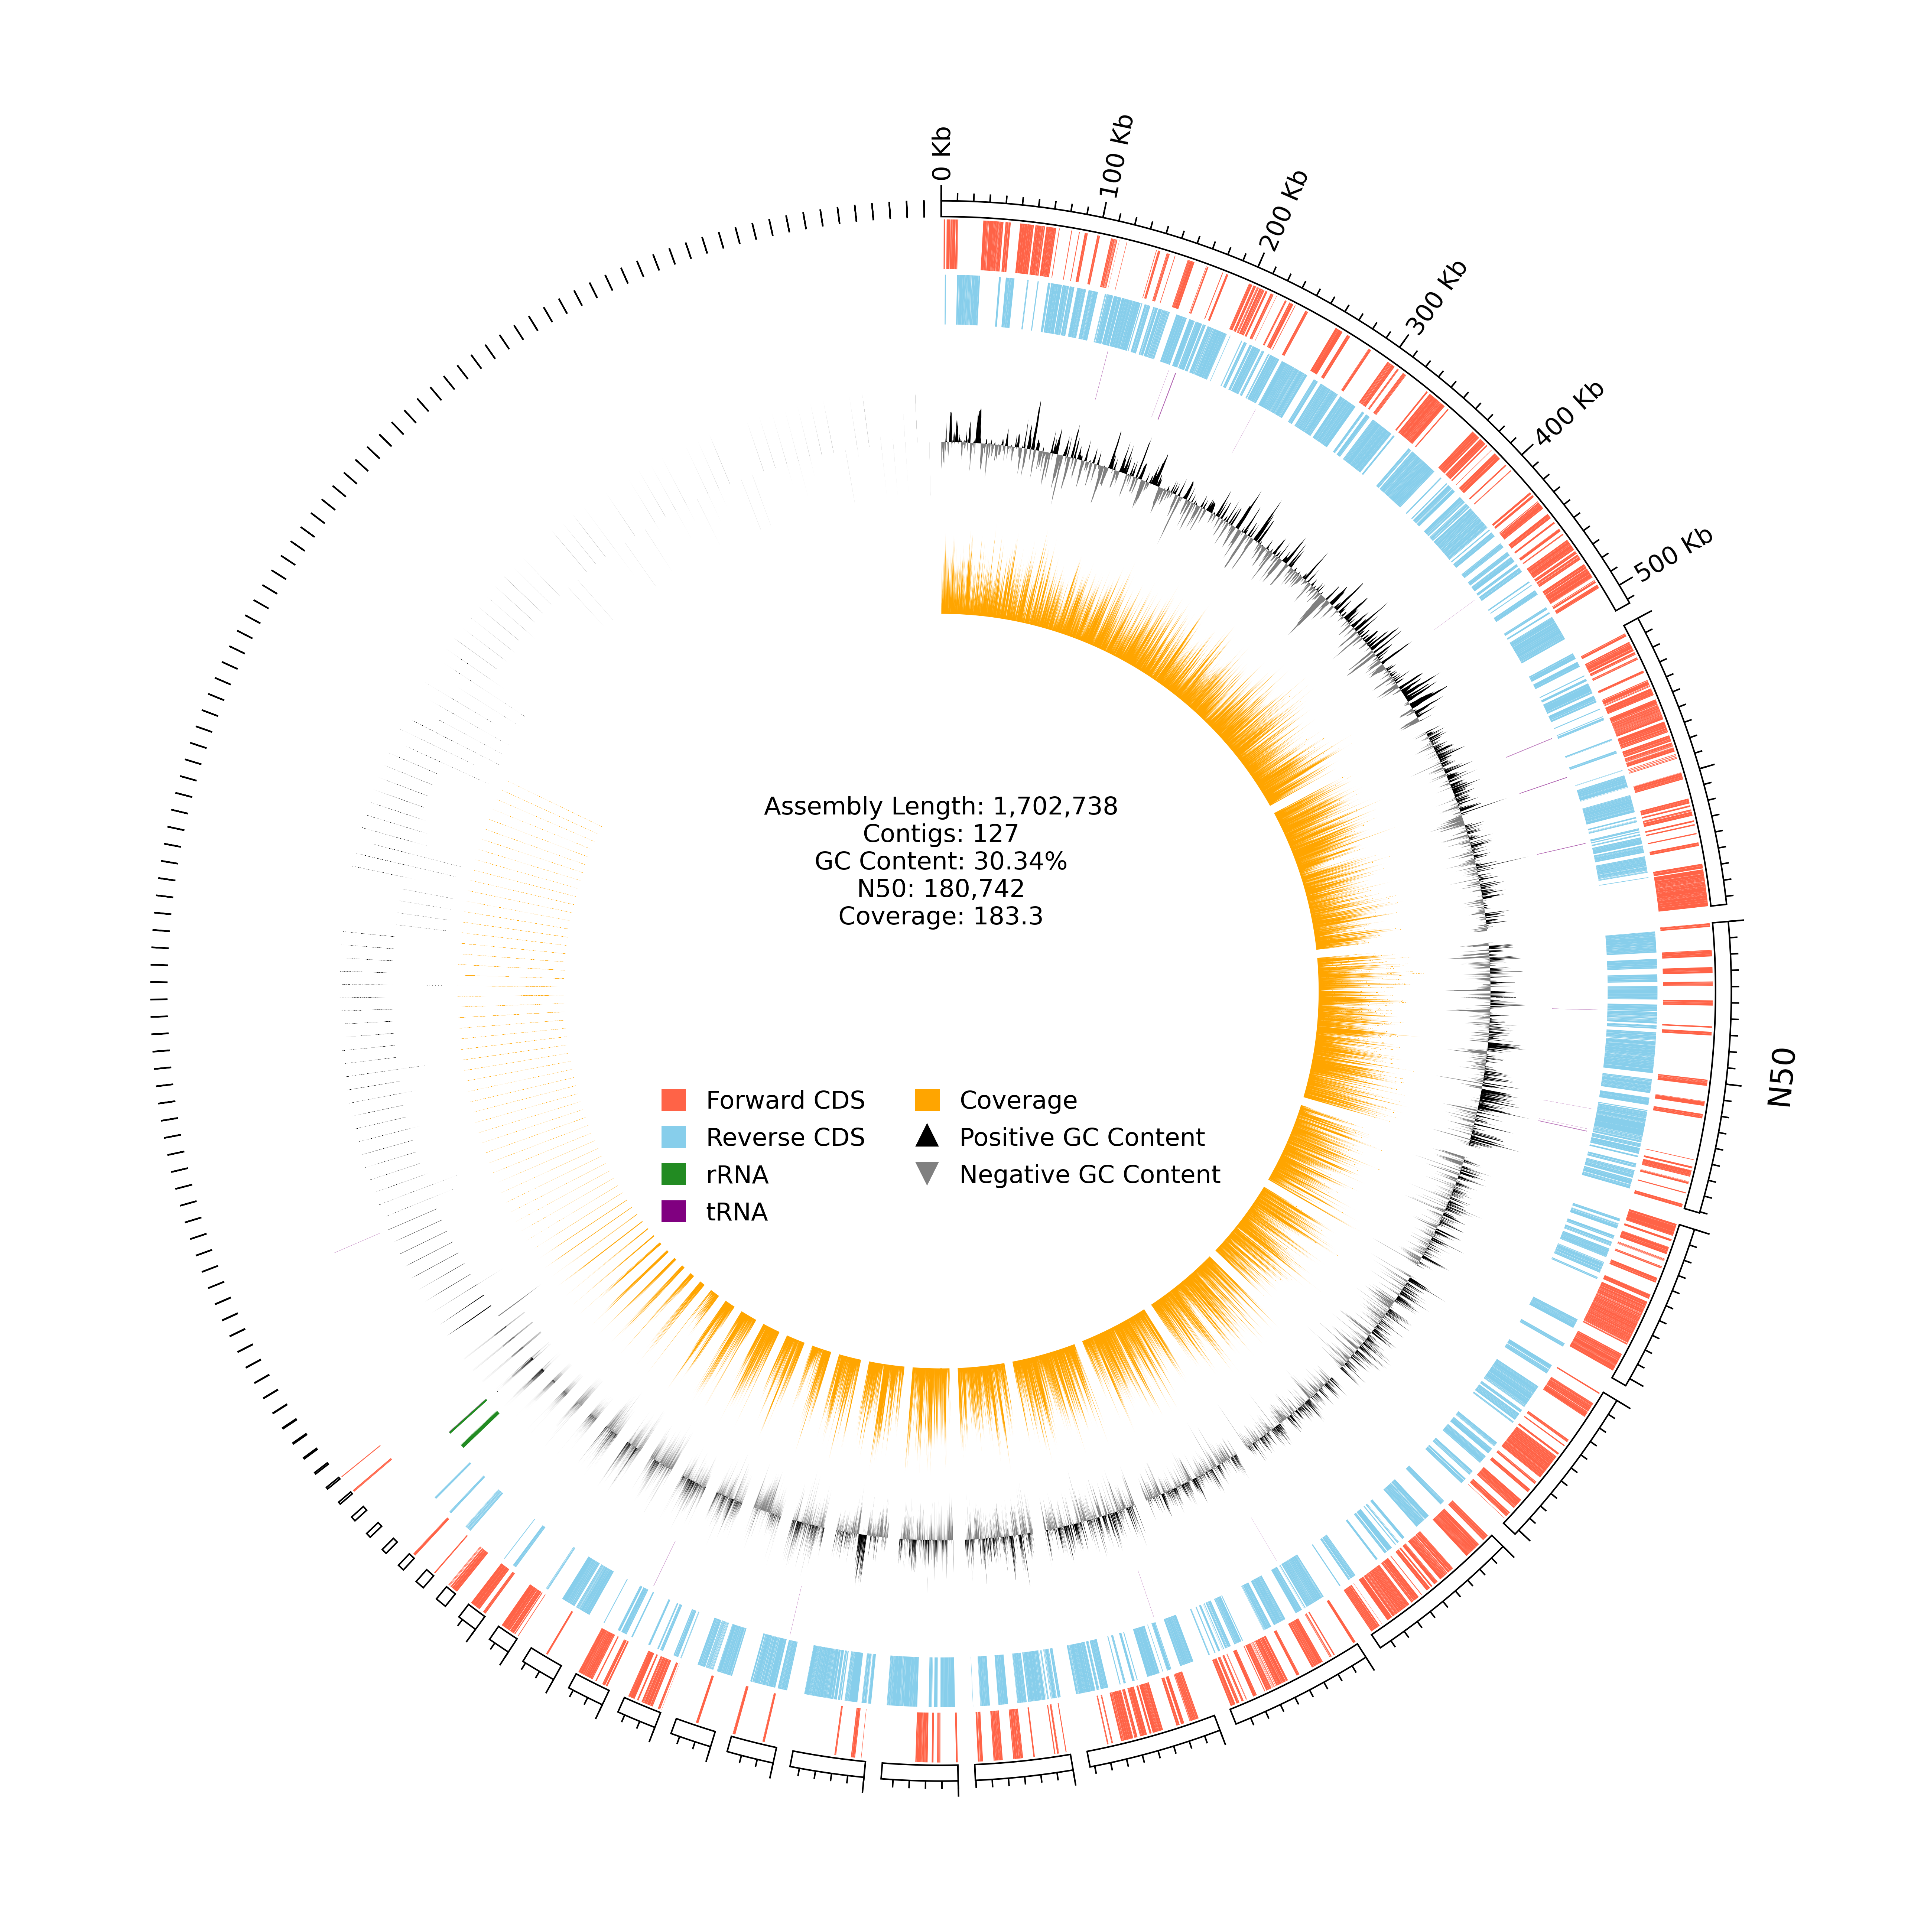

In [ ]:
Image(filename='circos_plot.png')

## Summary of Submodule02 outputs and wrap up

Throughout this submodule, we went through a detailed process of assessing our genome. This included assessment of the:

- **Contiguity** with QUAST, providing a metric on how well our genome is put back together.
- **Completeness** with BUSCO, providing a metric for the anticipated number of conserved single-copy orthologs.
- **Coverage** with BWA and samtools via read mapping, providing details about the depth of support for our bases in our genome and highlighting variably covered contigs.
- **Contamination** with BLAST and BlobTools, providing taxonomic information to help identify off-target sequences in our genome.
- **Content** with BAKTA, providing gene annotations and functional predictions to help characterize our genome.

Let's print out the detailed log file and make one last visual of the dataset. In the next submodule we will learn how to automate the processes you learned in this submodule and those from submodule 01 to generate many genome datasets. In submodule04 you will then utilize the outputs we generate, primarily the FAA annotation file, to perform comparataive analyses.

In [96]:
%%bash

cat genome-assessment-log.txt

Quast results:
# contigs                   30      
Largest contig              512707  
Total length                1693722 
GC (%)                      30.29   
N50                         180742  
----------------------------------
BUSCO results:
Complete and single-copy BUSCOs (S)	111
Complete and duplicated BUSCOs (D)	0
Fragmented BUSCOs (F)	6
Missing BUSCOs (M)	7
Total BUSCO groups searched	124
----------------------------------
Coverage results:
Average coverage =  183.732
----------------------------------
Coverage results:
Average depth of coverage =  183.732
----------------------------------
Contamination (blobtools taxonomy) results:
Contamination (blobtools taxonomy) results:
Contamination (blobtools taxonomy) results:
#Contigs\tPhylum\tSpecies\t
     40 no-hit	no-hit
     86 Proteobacteria	Campylobacter jejuni
      1 Proteobacteria	Campylobacter fetus
----------------------------------
Contamination (blobtools taxonomy) results:
    #Contigs  Phylum   Species
     40 no-

In [102]:
%%bash

# clean up files from submodule 02
mv genome* submodule02_data/
mv output-bakta output-busco output-quast submodule02_data/
mv sorted* logfile_quast.txt per_base_coverage.bed taxonomy.genome_data.blobDB.table.txt submodule02_data/
rm raw_mapped.sam
rm -r busco_downloads

<div class="alert alert-block alert-warning"> <b>Attention:</b> Before You Proceed: If you're not moving on immediately to the next submodule, be sure to shutdown your instance. </div>